In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import math as m
import statsmodels as sm
import statsmodels.api as sma
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc
from dask import delayed
from numba import jit
from scipy.stats import shapiro, kstest, ttest_ind, mannwhitneyu, fisher_exact, chi2_contingency, kruskal, wilcoxon, ttest_rel
from statsmodels.stats.contingency_tables import mcnemar, cochrans_q

from pandas.api.types import CategoricalDtype

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

In [2]:
"""
summary
"""

def to_array(df, col):
    return df[[col]].dropna().to_numpy()[:,0]


def cat_perc(var):
    n = round(np.sum(var),0)
    percents = round(n / len(var)*100, 1)
    return n, percents


def summ_numer(var):
    avg = np.mean(var) 
    sd = np.std(var) 
    mn = np.min(var) 
    mx = round(np.max(var),1)
    md = round(np.median(var),1)
    c25 = np.percentile(var, 25)
    c75 = np.percentile(var, 75)
    c2_5 = np.percentile(var, 2.5)
    c975 = np.percentile(var, 97.5)
    return avg, sd, mn, mx, md, c25, c75, c2_5, c975    

def summary_all(df, save_tab = False):
    summarize = pd.DataFrame()
    for col in df:
        v = df[col].name
        var = to_array(df, col)
        if len(np.unique(var)) == 1:
            vartype = 'Уникальная'
            n = round(len(var),0)
            med = avg = minn = maxx = sh = c2_5 = c975 = np.unique(var)
            percents = '-'
            N = len(var)
        elif len(np.unique(var)) < 3:
            v = df[col].name
            vartype = 'Категориальная'
            n, percents = cat_perc(var)
            percents = str(percents).join(' %')
            med = avg = minn = maxx = sh = c2_5 = c975 = '-'
            N = len(var)
        else:
            v = df[col].name
            vartype = 'Числовая'
            n = round(len(var),0)
            percents = '-'
            avg, sd, minn, maxx, md, c25, c75, c2_5, c975 = summ_numer(var)
            avg = ''.join([str(round(avg, 1)), ' ± ', str(round(sd, 1))])
            med = ''.join([str(round(md,1)), ' [',str(round(c25,1)),'; ',str(round(c75, 1)),']'])
            sh = kstest(var, cdf = 'norm')[1]
            if sh >= 0.001:
                sh = '{0:.3f}'.format(sh)
            else:
                sh = '< 0.001'                
            N = len(var)
            
        summarize = summarize.append({'Фактор': v, 'Тип': vartype, 'N':'% 6.0f' % N, 'Количество': '% 6.0f' % n, \
            'Доля, %': percents,'Медиана и 25/75 перцентили': med, 'Среднее и ст. отклонение': avg , \
            'Мин': minn, 'Макс': maxx, 'Критерий КС, р': sh, '2,5%': c2_5, '97,5%':c975}, ignore_index=True)
    summarize = summarize.reindex(columns=['Фактор', 'Тип', 'N','Количество', 'Доля, %', 'Мин', '2,5%','Медиана и 25/75 перцентили', '97,5%','Макс', 'Среднее и ст. отклонение', 'Критерий КС, р'])

    if save_tab == True:
        return pd.DataFrame.to_excel(summarize, 'Описательные статистики.xlsx')
    else:
        return summarize
    
def summary_num(df, save_tab = False):
    summarize = pd.DataFrame()
    for col in df:
        v = df[col].name
        var = to_array(df, col)
        if len(np.unique(var)) == 1:
            vartype = 'Уникальная'
            n = round(len(var),0)
            med = avg = minn = maxx = sh = c2_5 = c975 = np.unique(var)
        else:
            v = df[col].name
            vartype = 'Числовая'
            n = round(len(var),0)
            percents = '-'
            avg, sd, minn, maxx, md, c25, c75, c2_5, c975 = summ_numer(var)
            avg = ''.join([str(round(avg, 1)), ' ± ', str(round(sd, 1))])
            med = ''.join([str(round(md,1)), ' [',str(round(c25,1)),'; ',str(round(c75, 1)),']'])
            sh = kstest(var, cdf = 'norm')[1]
            if sh >= 0.001:
                sh = '{0:.3f}'.format(sh)
            else:
                sh = '< 0.001'                
            N = len(var)
            
        summarize = summarize.append({'Фактор': v, 'Тип': vartype, 'N':'% 6.0f' % N, 'Количество': '% 6.0f' % n, \
            'Медиана и 25/75 перцентили': med, 'Среднее и ст. отклонение': avg , \
            'Мин': minn, 'Макс': maxx, 'Критерий КС, р': sh, '2,5%': c2_5, '97,5%':c975}, ignore_index=True)
    summarize = summarize.reindex(columns=['Фактор', 'Тип', 'N','Количество', 'Мин', '2,5%','Медиана и 25/75 перцентили', '97,5%','Макс', 'Среднее и ст. отклонение', 'Критерий КС, р'])

    if save_tab == True:
        return pd.DataFrame.to_excel(summarize, 'Описательные статистики.xlsx')
    else:
        return summarize    

def summary_cat(df, save_tab = False):
    summarize = pd.DataFrame()
    for col in df:
        v = df[col].name
        var = to_array(df, col)
        n, percents = cat_perc(var)
        percents = str(percents).join(' %')
        N = len(var)
            
        summarize = summarize.append({'Фактор': v, 'N':'% 6.0f' % N, 'Количество': '% 6.0f' % n, 'Доля, %': percents}, ignore_index=True)
    summarize = summarize.reindex(columns=['Фактор', 'N','Количество', 'Доля, %'])

    if save_tab == True:
        return pd.DataFrame.to_excel(summarize, 'Описательные статистики.xlsx')
    else:
        return summarize
    
def summary(df, save_tab = False, method = 'all'):
    df = df
    save_tab = save_tab
    
    if method == 'all':
        return(summary_all(df, save_tab))
    elif method == 'num':
        return(summary_num(df, save_tab))
    elif method == 'cat':
        return(summary_cat(df, save_tab))
    else:
        return(print('ERROR: method is `all` or `num` or `cat`'))



In [12]:
'''
Import table

'''

path = 'C:/Users/lizag/OneDrive/Рабочий стол/Грейдирование/ЭКОПСИ Base_18.10.xlsx'

data = pd.read_excel(path, sheet_name = 0)

### Очистка и описание базы

In [13]:
'''
Find all NA's
'''

nulls = data.isna().sum().to_frame().reset_index()
nulls['NA Pers, %'] = round(nulls.iloc[:,1] / data.shape[0]*100, 1)
nulls.columns = ['Name', 'NA count', 'NA Pers, %']
nulls



,Name,NA count,"NA Pers, %"
0,ГК/Филиал,0,0.0
1,Подразделение,0,0.0
2,Департамент,308,14.9
3,Отдел,582,28.1
4,Должность,0,0.0
5,Номер,0,0.0
6,ФИО,0,0.0
7,Ставка,0,0.0
8,ФОТ,0,0.0
9,Регион,0,0.0


In [14]:
data['Департамент'] = data['Департамент'].fillna('999')
data['Отдел'] = data['Отдел'].fillna('999')

In [15]:
data = data.dropna()
data.shape

(2066, 19)

In [16]:
data = data[
     (data['Уровень необходимой квалификации'] > 0) &
     (data['Уровень необходимой квалификации'] < 7) &
     (data['Уровень свободы в принятии решений'] > 0) &
     (data['Уровень свободы в принятии решений'] < 6) &
     (data['Роль в формировании методологии и правил своего подразделения'] > 0) &    
     (data['Роль в формировании методологии и правил своего подразделения'] < 4) &
     (data['Роль в формировании методологии и правил Компании'] > 0) &    
     (data['Роль в формировании методологии и правил Компании'] < 5) &
     (data['Количество людей в административном подчинении'] > 0) &    
     (data['Количество людей в административном подчинении'] < 6) &    
     (data['Количество функциональных подчинённых ИЛИ внешних агентов, не находящихся в административном подчинении'] > 0) &    
     (data['Количество функциональных подчинённых ИЛИ внешних агентов, не находящихся в административном подчинении'] < 6) & 
     (data['Цель общения внутри Компании'] > 0) &    
     (data['Цель общения внутри Компании'] < 4) & 
     (data['Годовой объём прямого влияния на финансовый результат Компании '] > 0) &    
     (data['Годовой объём прямого влияния на финансовый результат Компании '] < 6) & 
     (data['Стоимость разовой ошибки'] > 0) &    
     (data['Стоимость разовой ошибки'] < 6) 
]

In [17]:
#Cоздаём столбец для вычисления зарплат по полной ставке
data['Полная ставка'] = (1 / data['Ставка']) * data['ФОТ']

# Удаляем значения ниже МРОТ (12 130 руб.)
data = data[data['Полная ставка'] > 12130]

In [18]:
data.shape

(1995, 20)

In [23]:
summary(data[['Уровень необходимой квалификации',
 'Уровень свободы в принятии решений',
 'Роль в формировании методологии и правил своего подразделения',
 'Роль в формировании методологии и правил Компании',
 'Количество людей в административном подчинении',
 'Количество функциональных подчинённых ИЛИ внешних агентов, не находящихся в административном подчинении',
 'Цель общения внутри Компании',
 'Годовой объём прямого влияния на финансовый результат Компании ',
 'Стоимость разовой ошибки',
 'Полная ставка']])

,Фактор,Тип,N,Количество,"Доля, %",Мин,"2,5%",Медиана и 25/75 перцентили,"97,5%",Макс,Среднее и ст. отклонение,"Критерий КС, р"
0,Уровень необходимой квалификации,Числовая,1995,1995,-,1.0,1.000000,2.0 [2.0; 4.0],5.0,6.0,2.8 ± 1.2,< 0.001
1,Уровень свободы в принятии решений,Числовая,1995,1995,-,1.0,1.000000,2.0 [2.0; 3.0],4.0,5.0,2.1 ± 0.8,< 0.001
2,Роль в формировании методологии и правил своег...,Числовая,1995,1995,-,1.0,1.000000,1.0 [1.0; 2.0],3.0,3.0,1.4 ± 0.6,< 0.001
3,Роль в формировании методологии и правил Компании,Числовая,1995,1995,-,1.0,1.000000,1.0 [1.0; 1.0],3.0,4.0,1.2 ± 0.6,< 0.001
4,Количество людей в административном подчинении,Числовая,1995,1995,-,1.0,1.000000,1.0 [1.0; 1.0],3.0,5.0,1.3 ± 0.7,< 0.001
5,Количество функциональных подчинённых ИЛИ внеш...,Числовая,1995,1995,-,1.0,1.000000,1.0 [1.0; 1.0],3.0,4.0,1.2 ± 0.6,< 0.001
6,Цель общения внутри Компании,Числовая,1995,1995,-,1.0,1.000000,1.0 [1.0; 2.0],3.0,3.0,1.6 ± 0.8,< 0.001
7,Годовой объём прямого влияния на финансовый ре...,Числовая,1995,1995,-,1.0,1.000000,1.0 [1.0; 2.0],4.0,5.0,1.5 ± 0.8,< 0.001
8,Стоимость разовой ошибки,Числовая,1995,1995,-,1.0,1.000000,1.0 [1.0; 1.0],3.0,5.0,1.2 ± 0.6,< 0.001
9,Полная ставка,Числовая,1995,1995,-,12180.0,14288.704687,50000.0 [29000.0; 90000.0],250000.0,600000.0,72015.6 ± 67942.9,< 0.001


### Регрессия

In [24]:
Y = data['Полная ставка']
X = data[['Уровень необходимой квалификации',
          'Уровень свободы в принятии решений',
          'Роль в формировании методологии и правил своего подразделения',
          'Роль в формировании методологии и правил Компании',
          'Количество людей в административном подчинении',
          'Количество функциональных подчинённых ИЛИ внешних агентов, не находящихся в административном подчинении',
          'Цель общения внутри Компании',
          'Годовой объём прямого влияния на финансовый результат Компании ',
          'Стоимость разовой ошибки']]

model_fitted = sm.OLS(Y, sm.add_constant(X)).fit()
model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Полная ставка   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     261.4
Date:                Fri, 18 Dec 2020   Prob (F-statistic):               0.00
Time:                        23:10:16   Log-Likelihood:                -24248.
No. Observations:                1995   AIC:                         4.852e+04
Df Residuals:                    1985   BIC:                         4.857e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================================================================
                                                                                                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                   -6.938e+04   3550.419    -19.542      0.000   -7.63e+04   -6.24e+04
Уровень необходимой квалификации                                                                          2.11e+04   1291.353     16.340      0.000    1.86e+04    2.36e+04
Уровень свободы в принятии решений                                                                       1.219e+04   2262.566      5.386      0.000    7749.080    1.66e+04
Роль в формировании методологии и правил своего подразделения                                           -1.102e+04   2981.280     -3.697      0.000   -1.69e+04   -5173.674
Роль в формировании методологии и правил Компании                                                        2.356e+04   2652.859      8.883      0.000    1.84e+04    2.88e+04
Количество людей в административном подчинении                                                           1.145e+04   2083.133      5.497      0.000    7365.246    1.55e+04
Количество функциональных подчинённых ИЛИ внешних агентов, не находящихся в административном подчинении -4476.8723   2229.435     -2.008      0.045   -8849.150    -104.595
Цель общения внутри Компании                                                                             5997.0257   1849.127      3.243      0.001    2370.593    9623.459
Годовой объём прямого влияния на финансовый результат Компании                                           7772.6209   1888.921      4.115      0.000    4068.145    1.15e+04
Стоимость разовой ошибки                                                                                 1.031e+04   2417.321      4.264      0.000    5565.530     1.5e+04
==============================================================================
Omnibus:                     1092.719   Durbin-Watson:                   1.147
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14433.761
Skew:                           2.288   Prob(JB):                         0.00
Kurtosis:                      15.357   Cond. No.                         19.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

KstestResult(statistic=1.0, pvalue=0.0)

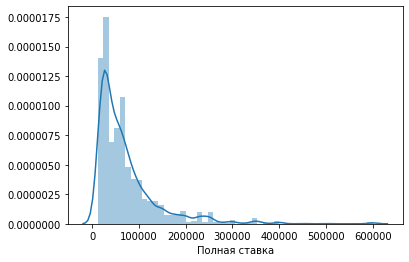

In [26]:
sns.distplot(data['Полная ставка'])

kstest(data['Полная ставка'], cdf='norm')

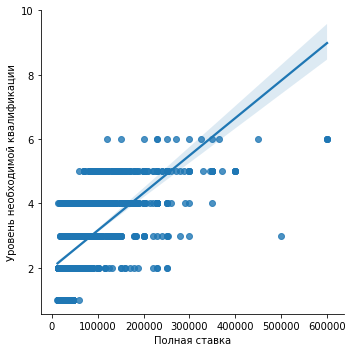

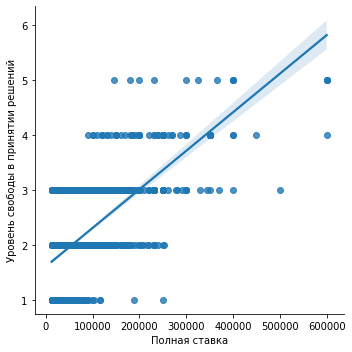

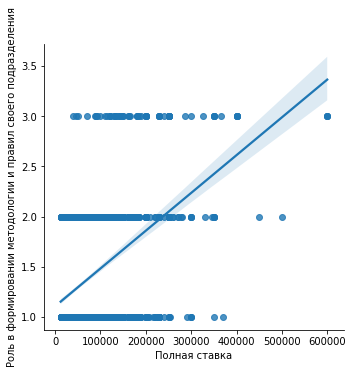

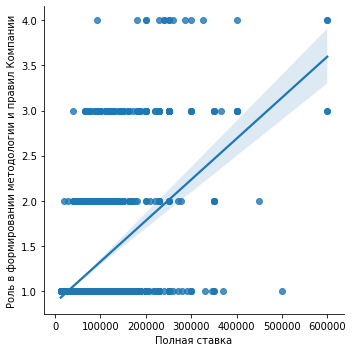

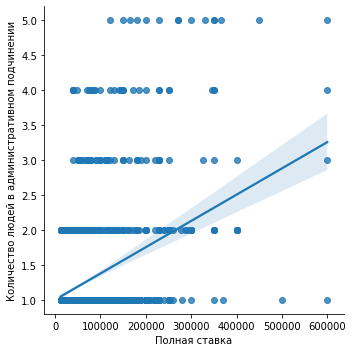

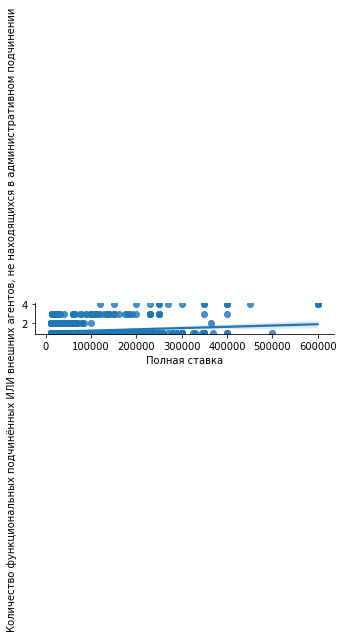

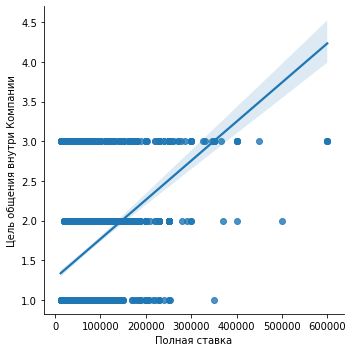

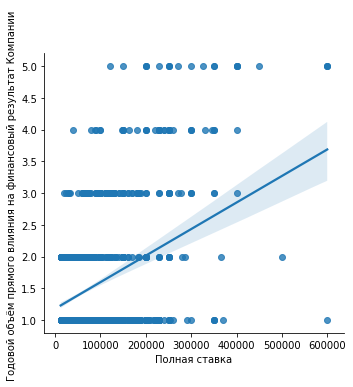

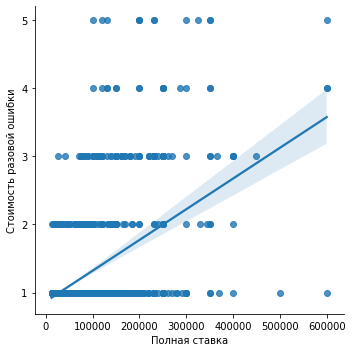

In [27]:
for col in ['Уровень необходимой квалификации',
          'Уровень свободы в принятии решений',
          'Роль в формировании методологии и правил своего подразделения',
          'Роль в формировании методологии и правил Компании',
          'Количество людей в административном подчинении',
          'Количество функциональных подчинённых ИЛИ внешних агентов, не находящихся в административном подчинении',
          'Цель общения внутри Компании',
          'Годовой объём прямого влияния на финансовый результат Компании ',
          'Стоимость разовой ошибки']:
    sns.lmplot('Полная ставка', col, data=data)
    plt.show()

In [28]:
# Создание коэфициеннтов из модели
koef = model_fitted.params[1:]

In [29]:
koef = pd.Series(koef)

koef.to_excel('Веса_критериев.xlsx')
koef

Уровень необходимой квалификации                                                                           21100.179759
Уровень свободы в принятии решений                                                                         12186.334413
Роль в формировании методологии и правил своего подразделения                                             -11020.439835
Роль в формировании методологии и правил Компании                                                          23564.236307
Количество людей в административном подчинении                                                             11450.603767
Количество функциональных подчинённых ИЛИ внешних агентов, не находящихся в административном подчинении    -4476.872300
Цель общения внутри Компании                                                                                5997.025733
Годовой объём прямого влияния на финансовый результат Компании                                              7772.620941
Стоимость разовой ошибки                

### Интегральный балл и грейды

In [30]:
tab = pd.DataFrame()
for j, col in zip(koef, koef.index):
    tab[col] = data[col] * j

data['Интегральный балл'] = tab.sum(axis=1)

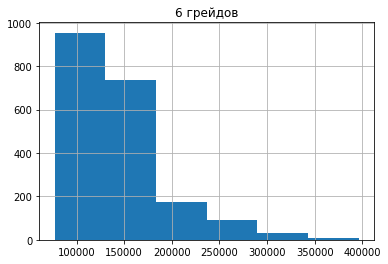

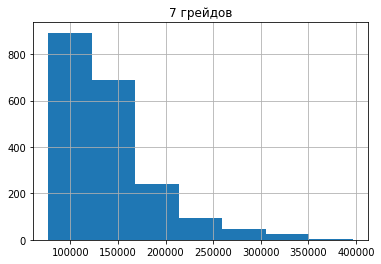

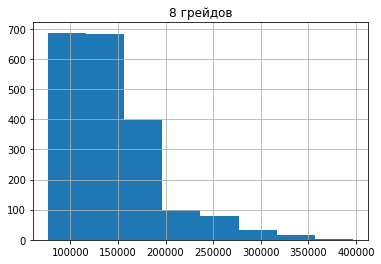

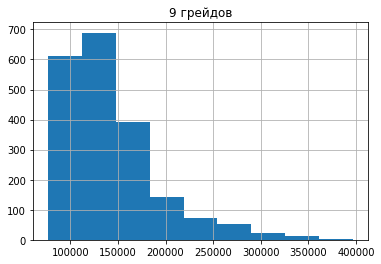

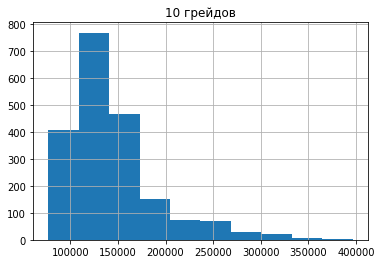

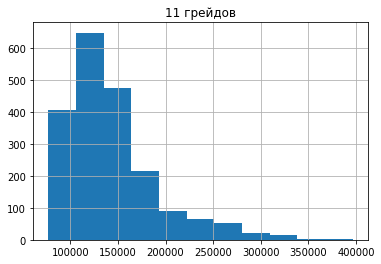

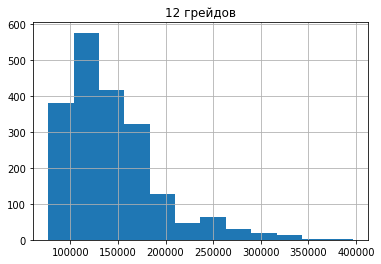

In [31]:
for i in range(6,13):
    data['Интегральный балл'].hist(bins=i)
    plt.title(str(i) + ' грейдов')
    plt.show()

In [32]:
grades_fot = np.array_split(range(int(data['Интегральный балл'].min()), int(data['Интегральный балл'].max())), 8)

def grades(x):
  for i, grade in enumerate(grades_fot):
    if int(x) in grade:
      return int(i+1)

data['Грейд'] = data['Интегральный балл'].apply(grades, 0)
data['Грейд'] = data['Грейд'].fillna(8)

In [39]:
data[['Интегральный балл', 'Грейд']].groupby('Грейд').agg([min, max])

Интегральный балл               
                    min            max
Грейд                                 
1          76879.972323  116593.676160
2         117939.107436  153962.904523
3         158363.871746  196317.105782
4         197546.051808  235757.583251
5         237187.053772  274615.871695
6         276871.755773  314580.765277
7         323803.506536  351138.381959
8         386558.751005  396459.505572

In [33]:
data[['Грейд', 'Полная ставка']].groupby('Грейд').describe()

Полная ставка                                                    \
              count           mean            std       min       25%   
Грейд                                                                   
1             687.0   35460.909934   20357.754765   12180.0   21250.0   
2             683.0   58546.833807   45358.480901   12742.0   30000.0   
3             397.0   96364.622796   51221.209616   12687.5   61500.0   
4              98.0  125196.346939   60185.472307   18742.0   90000.0   
5              80.0  187923.812500  100796.498122   40000.0  115000.0   
6              32.0  244750.000000   74771.048391  130000.0  197500.0   
7              15.0  313666.666667  146634.466162  120000.0  230000.0   
8               3.0  408333.333333  166458.202962  300000.0  312500.0   

                                     
            50%       75%       max  
Грейд                                
1       30000.0   46750.0  250000.0  
2       50000.0   71000.0  500000.0  
3       85500.0  120000.0  370000.0  
4      112500.0  150000.0  350000.0  
5      163750.0  235000.0  600000.0  
6      245000.0  290250.0  400000.0  
7      260000.0  382500.0  600000.0  
8      325000.0  462500.0  600000.0

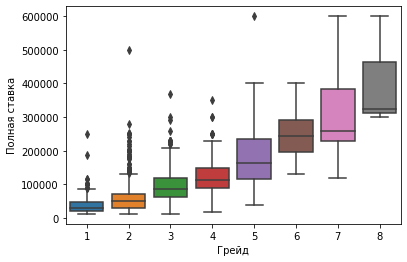

In [34]:
data['Грейд'] = (data['Грейд']).astype('category')

sns.boxplot('Грейд', 'Полная ставка', data=data)


### Региональные коэффициенты

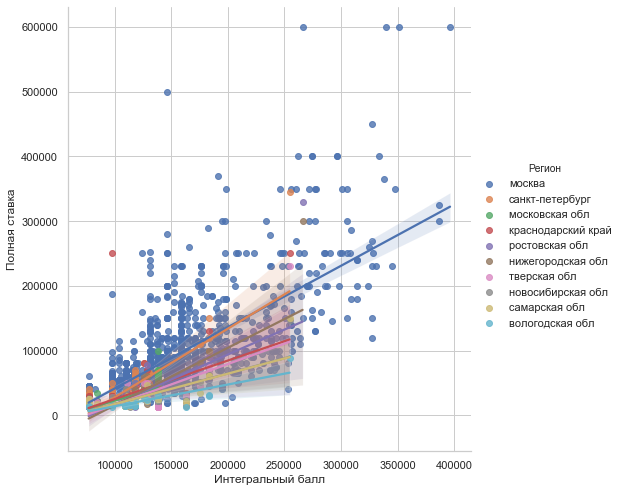

In [35]:
sns.set(style = 'whitegrid')
sns.lmplot(data=data, x='Интегральный балл', y='Полная ставка', hue="Регион", height=7)

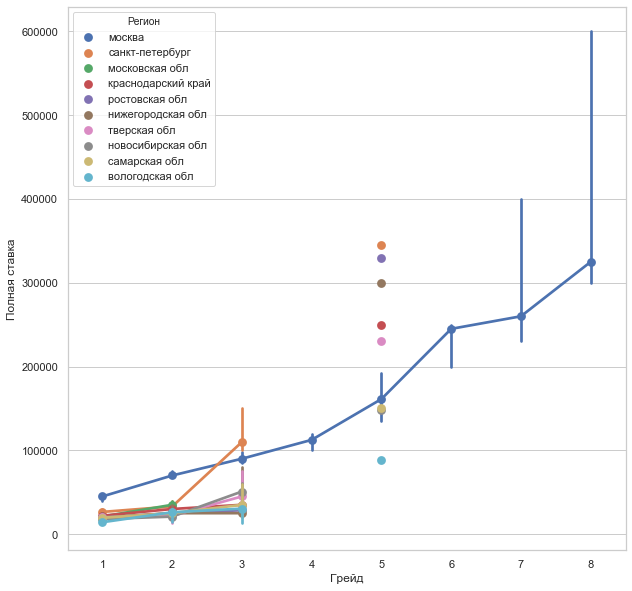

In [36]:
fig, ax = plt.subplots(figsize=(10,10))
sns.pointplot(data=data, x='Грейд', y='Полная ставка', hue="Регион",ax=ax, estimator=np.median)

In [37]:
data.groupby('Регион')['Полная ставка'].agg(['min', 'max', 'median'])

,min,max,median
Регион,,,
вологодская обл,12180.0,88305.0,15225.0
краснодарский край,12608.0,250000.0,25500.0
москва,18742.0,600000.0,70000.0
московская обл,13750.0,100000.0,28000.0
нижегородская обл,15000.0,300000.0,24250.0
новосибирская обл,13325.0,147600.0,20500.0
ростовская обл,12742.0,330000.0,21000.0
самарская обл,14500.0,150000.0,22350.0
санкт-петербург,17000.0,345000.0,30000.0


In [38]:
reg_coefs = pd.Series(data.groupby('Регион')['Полная ставка'].agg('median')/ np.median(data[data['Регион'] == 'москва']['Полная ставка']))

In [40]:
data['Региональный коэффициент'] = data['Регион'].replace(list(reg_coefs.index), list(reg_coefs))

In [41]:
reg_coefs

Регион
вологодская обл       0.217500
краснодарский край    0.364286
москва                1.000000
московская обл        0.400000
нижегородская обл     0.346429
новосибирская обл     0.292857
ростовская обл        0.300000
самарская обл         0.319286
санкт-петербург       0.428571
тверская обл          0.285714
Name: Полная ставка, dtype: float64

### Вилки ЗП

In [42]:
step = 0.14

reg_stavka = data[['Регион','Грейд', 'Полная ставка']].groupby(['Регион','Грейд']).median()
lower_r_s = (reg_stavka - reg_stavka*step).reset_index()
upper_r_s = (reg_stavka + reg_stavka*step).reset_index()
reg_stavka_grade_med = reg_stavka.reset_index()

lower_r_s.columns = ['Регион','Грейд', 'Нижний предел ставки']
upper_r_s.columns = ['Регион','Грейд', 'Верхний предел ставки']
reg_stavka_grade_med.columns = ['Регион','Грейд', 'Медианная ставка']


In [43]:
data = pd.merge(pd.merge(pd.merge(data, reg_stavka_grade_med, on=['Регион','Грейд']), upper_r_s, on=['Регион','Грейд']), lower_r_s, on=['Регион','Грейд'])

### Целевой доход

In [44]:
def person(row):
    x = data.loc[row, ['Регион','Грейд', 'Полная ставка', 'Медианная ставка', 'Нижний предел ставки', 'Верхний предел ставки']]
    return(pd.Series(x))

def new_stavka(P):
    if P[2] >= P[5]:
        stavka = P[5]
    elif  P[2] <= P[4]:
        stavka = P[4]
    elif P[3] > P[2] > P[2]:
        stavka = P[3]
    else:
        stavka = P[2]
    return(stavka)

In [45]:
a = []

data['Целевой доход'] = np.array([new_stavka(person(i)) for i in data.index])

In [47]:
data.head()

,ГК/Филиал,Подразделение,Департамент,Отдел,Должность,Номер,ФИО,Ставка,ФОТ,Регион,Уровень необходимой квалификации,Уровень свободы в принятии решений,Роль в формировании методологии и правил своего подразделения,Роль в формировании методологии и правил Компании,Количество людей в административном подчинении,"Количество функциональных подчинённых ИЛИ внешних агентов, не находящихся в административном подчинении",Цель общения внутри Компании,Годовой объём прямого влияния на финансовый результат Компании,Стоимость разовой ошибки,Полная ставка,Интегральный балл,Грейд,Региональный коэффициент,Медианная ставка,Верхний предел ставки,Нижний предел ставки,Целевой доход
0,Головная компания,Блок андеррайтинга,Департамент бизнес-анализа и технологий,999,Аналитик,1424452,Ячменькова Пелагея Андрияновна,1.0,90000.0,москва,4.0,3.0,1,1,1,1.0,2,1,1,90000.0,170550.206159,3,1.0,90000.0,102600.0,77400.0,90000.0
1,Головная компания,Блок андеррайтинга,Департамент бизнес-анализа и технологий,999,Аналитик,6667954,Горелов Архип Геннадиевич,1.0,90000.0,москва,4.0,3.0,1,1,1,1.0,2,1,1,90000.0,170550.206159,3,1.0,90000.0,102600.0,77400.0,90000.0
2,Головная компания,Блок андеррайтинга,Департамент бизнес-анализа и технологий,999,Аналитик,7284288,Яшнова Лилия Владиленовна,1.0,130000.0,москва,4.0,2.0,1,1,1,1.0,2,1,1,130000.0,158363.871746,3,1.0,90000.0,102600.0,77400.0,102600.0
3,Головная компания,Блок андеррайтинга,Департамент бизнес-анализа и технологий,999,Аналитик,7586757,Абоймова Ефросинья Ильевна,1.0,130000.0,москва,4.0,2.0,1,1,1,1.0,2,1,1,130000.0,158363.871746,3,1.0,90000.0,102600.0,77400.0,102600.0
4,Головная компания,Блок андеррайтинга,Департамент оперативного андеррайтинга,999,Главный андеррайтер,3339290,Сонин Сергей Давидович,1.0,85000.0,москва,4.0,2.0,1,1,1,1.0,3,2,3,85000.0,192746.085497,3,1.0,90000.0,102600.0,77400.0,85000.0


In [46]:
data.to_excel('Экопси 18_12_2020.xlsx')

### Ура!